# Sesión 3.2. Redes recurrentes - Predicción de valores de bolsa
Curso 2022-23

Profesor: Jorge Calvo Zaragoza (<jcalvo@dlsi.ua.es>)


## Descripción

---
La predicción de valores de bolsa es un de los problemas más conocidos y aplicados. La predicción depende de muchos factores externos que por simplicidad no analizaremos y únicamente nos centraremos en las cotizaciones durante un periodo temporal.

---


# Introducción

El análisis de series temporales se refiere al análisis del cambio en la tendencia de los datos a lo largo de un período de tiempo. Este análisis tiene una gran variedad de aplicaciones. Una de estas aplicaciones es la predicción de valores futuros basadas en sus valores pasados. La predicción del precio futuro de las acciones es probablemente el mejor ejemplo de una aplicación de este tipo. En este ejercicio, plantearemos cómo podemos realizar el análisis temporal con la ayuda de una red neuronal recurrente. Predeciremos los precios futuros de las acciones de la Apple Company (AAPL) basándonos en los precios de las acciones de los últimos 5 años.

# Conjunto de datos

Los datos que vamos a utilizar para esta actividad se pueden descargar de [Yahoo Finance](https://finance.yahoo.com/quote/AAPL/history?p=AAPL&.tsrc=fin-srch&guccounter=1&guce_referrer=aHR0cHM6Ly9zdGFja2FidXNlLmNvbS8&guce_referrer_sig=AQAAAKTyTaVfjMrISuvNNeO-Br47RyosTAY1GVIYQh4vPKo8QwHX3xX-7UyMQIH8VEg-yHFQVR1UtJ7fWxgw8BabaCmpPEM5uSzlqLYx9l2c3K46YZgml_9jtnHCc44gzaT8gp9myqnhtq2b-zdqzdwLBIrFG9M5RrgCMu_LWLP6VXwq) aunque también proporcionaremos una copia de estos valores en el fichero `AAPL.csv`. Para el entrenamiento de de nuestro sistema utilizaremos las cotizaciones bursátiles de Apple desde el 1 de enero de 2013 hasta el 31 de diciembre de 2017. Para la predicción, utilizaremos los precios de las acciones de Apple para el mes de enero de 2018.

Veamos ahora cómo se ven nuestros datos. Abre el archivo de formación sobre el precio de las acciones de Apple que contiene los datos de los últimos cinco años. Contiene siete columnas: `Date', 'Open', 'High', 'Low', 'Close', 'Adj Close' y 'Volume`. Nos interesa predecir el precio de apertura de la acción (`Open`) , por lo tanto descartaremos el resto de la columnas.

In [33]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.random.set_seed(1)  # Fijamos la semilla de TF
np.random.seed(1)  # Fijamos la semilla

data = pd.read_csv('https://www.dlsi.ua.es/~jcalvo/curso-deep-learning/AAPL.csv', parse_dates=['Date'])
display(data.head())
data.dtypes

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-12-31,72.932854,76.485718,72.714287,76.024284,67.190933,164873100
1,2013-01-02,79.117142,79.285713,77.375717,78.432854,69.319641,140129500
2,2013-01-03,78.268570,78.524284,77.285713,77.442856,68.444672,88241300
3,2013-01-04,76.709999,76.947144,75.118568,75.285713,66.538162,148583400
4,2013-01-07,74.571426,75.614288,73.599998,74.842857,66.146751,121039100


Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

# Visualizar los valores de apertura

<Axes: >

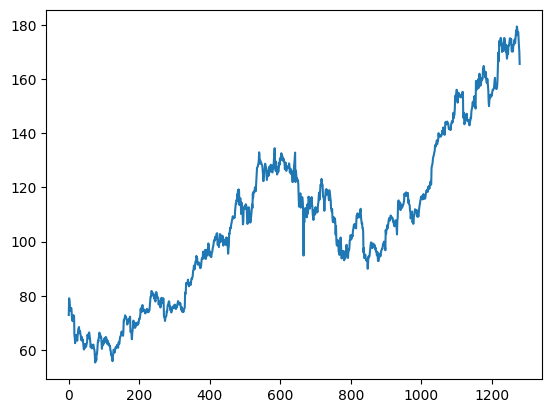

In [34]:
data['Open'].plot() # TODO: Visualiza los datos de la columna "Open"

Se puede ver que la tendencia no es lineal y difícil capturar esta información. Las redes recurrentes como las tipo LSTM nos pueden ayudar ya que son capaces de recordar la información del pasado, al tiempo que predice los valores futuros.

# Normalizar los datos

Como regla general, cuando se utilicen redes neuronales se deben normalizar o escalar los datos. En nuetro caso vamos a usar la clase `MinMaxScaler` de la biblioteca `sklearn.preprocessing` para transformarlos en valores  entre 0 y 1. El parámetro `feature_range` se utiliza para especificar el rango de los datos escalados.

In [35]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler(feature_range = (0, 1) ) # TODO: Especifica que el rango de la caracteristica debe estar entre 0 y 1

data['Open Scaled'] = scaler.fit_transform(data['Open'].values.reshape(-1, 1))
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Open Scaled
0,2012-12-31,72.932854,76.485718,72.714287,76.024284,67.190933,164873100,0.141260
1,2013-01-02,79.117142,79.285713,77.375717,78.432854,69.319641,140129500,0.191155
2,2013-01-03,78.268570,78.524284,77.285713,77.442856,68.444672,88241300,0.184309
3,2013-01-04,76.709999,76.947144,75.118568,75.285713,66.538162,148583400,0.171734
4,2013-01-07,74.571426,75.614288,73.599998,74.842857,66.146751,121039100,0.154480


# Convertir datos de entrenamiento a la forma correcta

Como vamos a predecir el seguiente valor teniendo en cuenta los valores pasados vamos a transformar el único vector de entrada en una matriz que contenga N valores anteriores y como predicción el valor siguiente. Según el artículo referenciado, se recomienda un valor de N=60 pero se pueden probar alternativas y comprobar su comportamiento en la predicción.


In [36]:
N=60

#Valores de apertura en un vector
scaled_values = data['Open Scaled'].values

X = [] # Matriz base para predecir
y = [] # Vector con la predicciones
for i in range(N, len(scaled_values)):
  X.append(scaled_values[i-N:i])
  y.append(scaled_values[i])

X = np.array(X)
y = np.array(y)


print('X.shape', X.shape ) # TODO: Imprime la forma del vector X
print('X[:5]',  X[:5] )    # TODO: Imprime los 5 primeros valores del vector X
print('y.shape', y.shape ) # TODO: Imprime la forma del vector y
print('y[:5]', y[:5] )     # TODO: Imprime los 5 primeros valores del vector y

X.shape (1220, 60)
X[:5] [[0.14125998 0.19115511 0.18430879 0.17173417 0.15448006 0.16279014
  0.15505639 0.16202945 0.15332752 0.13221229 0.12716397 0.12294553
  0.14100643 0.12741751 0.13437913 0.13927755 0.08302023 0.07344231
  0.05746755 0.08129135 0.07956247 0.07953945 0.08199442 0.076001
  0.0646366  0.07895161 0.08676612 0.09915632 0.10203774 0.10550701
  0.09133031 0.08822988 0.09322052 0.08428806 0.08035776 0.06688413
  0.07063002 0.07593187 0.06437151 0.06968491 0.0646366  0.0576635
  0.04590719 0.03862291 0.05364099 0.04210368 0.04821237 0.04815472
  0.05489732 0.04665636 0.05170468 0.05758281 0.06163988 0.08244395
  0.08004654 0.07174803 0.07677326 0.0884258  0.08929027 0.07894009]
 [0.19115511 0.18430879 0.17173417 0.15448006 0.16279014 0.15505639
  0.16202945 0.15332752 0.13221229 0.12716397 0.12294553 0.14100643
  0.12741751 0.13437913 0.13927755 0.08302023 0.07344231 0.05746755
  0.08129135 0.07956247 0.07953945 0.08199442 0.076001   0.0646366
  0.07895161 0.08676612 0.

# Creando la red recurrente tipo LSTM

Se han preprocesado los datos y los hemos convertido al formato correcto. Ahora tenemos que diseñar nuestra red para entrenarla y realizar las predicciones.

En el caso de las redes recurrentes necesitamos una dimensión de entrada extra ya que necesitamos `(batch_size, time_steps, feature_size)` y nos faltaría la dimensión del `feature_size`.

In [37]:
# Adaptación de la matriz de datos a redes recurrentes
X = np.expand_dims(X, axis=-1) #
print(X.shape)

(1220, 60, 1)


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

input_shape = X.shape[1:]

model =  Sequential()    # TODO: Define un modelo secuencial
model.add(LSTM(128, input_shape=input_shape)) # TODO: Añade una LSTM de 128 unidades (junto con las dimensiones de entrada)
model.add(Dropout(0.2)) # TODO: Añade una capa de Dropout del 20 %
model.add(Dense(1)) # TODO: Añade una capa densa de una neurona

model.compile(optimizer='adam', loss='mean_squared_error')  # TODO: Compila el model con el optimizador Adam y una pérdida de error cuadrático medio

model.summary()

(60, 1)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


# Entrenamiento del modelo

Vamos a dividir el conjunto en entrenamiento y test para comprobar nuestro modelo. Para ello vamos a reservar los últimos 30 días para realizar las predicciones.

In [41]:
X_train = X[:-30]
X_test = X[-29:len(X)]        # TODO: Crea la particiones de test para el vector X

y_train = y[:-30]
y_test =  y[-29:len(y)]       # TODO: Crea las particiones de train y test para el vector y

In [42]:
model.fit(X_train, y_train, 32, 50 )        # TODO: Entrena el modelo durante 50 épocas, con un tamaño de batch de 32

Epoch 1/50
38/38 [==============================] - 3s 7ms/step - loss: 0.0201
Epoch 2/50
38/38 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 3/50
38/38 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 4/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 5/50
38/38 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 6/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 7/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 8/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 9/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 10/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 11/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 12/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 13/50
38/38 [==============================

# Predicciones con el test

In [43]:
y_pred =   model.predict(X_test)            # TODO: Obtén las predicciones sobre el conjunto de test

1/1 [==============================] - 0s 331ms/step


# Visualización de resultados

Visualización de los últimos días reales (60) junto a los 30 días de predicción.

<Axes: >

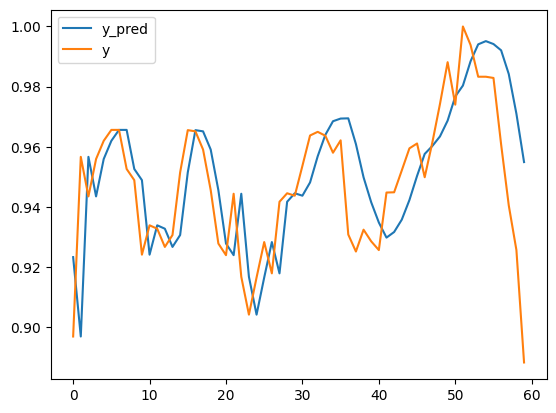

In [44]:
y_pred_last = np.concatenate((y_train,y_pred.ravel()))[-60:]
y_last = y[-60:]
pd.DataFrame({'y_pred':y_pred_last, 'y':y_last}).plot()